In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
def _get_qnet(df):
    from quasinet import qnet

    qn = qnet.Qnet(
        feature_names=df.columns.values,
        min_samples_split=2,
        alpha=0.05,
        max_depth=-1,
        max_feats=-1,
        early_stopping=False,
        verbose=0,
        random_state=None,
        n_jobs=-1,
    )

    qn.fit(df.to_numpy(dtype="<U21"))

    return qn


def _get_tnets(df, df_pos, df_neg):
    non_null_cols = (
        (df.isna().sum() < len(df))
        & (df_pos.isna().sum() < len(df_pos))
        & (df_neg.isna().sum() < len(df_neg))
    )

    Tr = _get_qnet(df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""))
    Tr_pos = _get_qnet(
        df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
    )
    Tr_neg = _get_qnet(
        df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
    )

    return {"all": Tr, "pos": Tr_pos, "neg": Tr_neg}


from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _sample_with_dissonance(
    sample_model, length, diss_models, diss_fcn=_diss_linear, order=None
):
    if order is None:
        order = range(length)

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    feature_vecs = list()

    for i in order:
        prob_dict = sample_model.predict_distribution(sample, i)
        sample[i] = sample_from_dict(prob_dict)
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _nsamples_with_dissonance(
    n_samples, sample_model, length, diss_models, diss_fcn=_diss_linear, order=None
):
    samples = list()
    dissonances = list()

    for i in tqdm(range(n_samples)):
        samp, diss = _sample_with_dissonance(
            sample_model, length, diss_models, diss_fcn, order
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


# generate samples under the given models and compute dissonances under specified diss_models
def _sampling_scenario(
    n_qsamples,
    qsample_model,
    n_m2_samples,
    m2_model,
    diss_models,
    length,
    diss_fcn=_diss_linear,
    order=None,
):
    samples = {}
    dissonances = {}

    if order == "entropy":
        Ds = qsample_model.predict_distributions(np.full(length, ""))
        entrpy = list()
        for i in range(len(Ds)):
            entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
        order = pd.Series(entrpy).sort_values().index

    if order == "random":
        order = list(range(length))
        random.shuffle(order)

    samples["qsampled"], dissonances["qsampled"] = _nsamples_with_dissonance(
        n_qsamples, qsample_model, length, diss_models, diss_fcn, order
    )

    samples["m2"], dissonances["m2"] = _nsamples_with_dissonance(
        n_m2_samples, m2_model, length, diss_models, diss_fcn, order
    )

    return samples, dissonances


def _diss_dataset(dissonances, questions_asked):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in ["qsampled", "m2"]
        ]
    )
    return diss_dataset


def _save_sampling_scenarios(
    n, n_qsamples, n_m2_samples, diss_fcn=_diss_linear, order=None
):
    for i in tqdm(range(n)):
        glbl = _get_tnets(
            pd.read_csv("data/gibbons_global/gibbons_global.csv"),
            pd.read_csv("data/gibbons_global/gibbons_global_pos.csv"),
            pd.read_csv("data/gibbons_global/gibbons_global_neg.csv"),
        )

        full_model = glbl["all"]
        pos_model = glbl["pos"]
        neg_model = glbl["neg"]

        length = len(full_model.feature_names)

        diss_models = [full_model, neg_model, pos_model]

        s, d = _sampling_scenario(
            n_qsamples,
            full_model,
            n_m2_samples,
            pos_model,
            diss_models,
            length,
            diss_fcn,
            order,
        )

        pd.to_pickle(s, "samps_global_" + str(order) + "_order_" + str(i) + ".pkl")
        pd.to_pickle(d, "disson_global_" + str(order) + "_order_" + str(i) + ".pkl")

Example:

In [ ]:
full_model = glbl["all"]
pos_model = glbl["pos"]
neg_model = glbl["neg"]

diss_models = [full_model, neg_model, pos_model]
n_qsamples = 10
n_m2_samples = 10

s, d = _sampling_scenario(
    n_qsamples,
    full_model,
    n_m2_samples,
    pos_model,
    diss_models,
    len(full_model.feature_names),
)

In [ ]:
_save_sampling_scenarios(10, 50, 50, order="entropy")

In [4]:
_save_sampling_scenarios(10, 50, 50, order="random")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Classification

In [3]:
# diss = [pd.read_pickle(d) for d in glob.glob("disson_global/disson*.pkl")]

diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_global/disson_global_random_order*.pkl")
]

Quick test

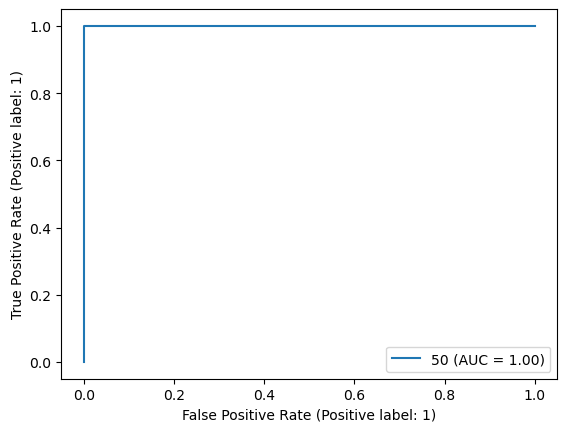

In [4]:
questions_asked = 50
data = _diss_dataset(diss[0], questions_asked)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            "qsampled": 0,
            "m2": 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            "qsampled": 0,
            "m2": 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

Below, note that each dissonance file contains dissonances computed on retrained qnets (one set of qnets per file).  We also fit a classifier `retrains` times to get average performance on each file/set of models.

In [5]:
auc_dfs = list()
plot = False
retrains = 3
n_trials = 20
question_iter = range(25, 32, 1)
question_iter = range(1, 102, 5)
res = "all_diss"

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }
                # param = {
                #    "objective": "binary",
                #    "metric": "auc",
                #    "verbosity": -1,
                #    "boosting_type": "gbdt",
                #    "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                #    "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                #    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                #    "feature_fraction": trial.suggest_float(
                #        "feature_fraction", 0.4, 1.0
                #    ),
                #    "bagging_fraction": trial.suggest_float(
                #        "bagging_fraction", 0.4, 1.0
                #    ),
                #    "bagging_freq": trial.suggest_int("bagging_freq", 1, #7),
                #    "min_child_samples": trial.suggest_int#("min_child_samples", 5, 100),
                # }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            "qsampled": 0,
                            "m2": 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            "qsampled": 0,
                            "m2": 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        "qsampled": 0,
                        "m2": 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        "qsampled": 0,
                        "m2": 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        "qsampled": 0,
                        "m2": 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            "data/classification/global/rf_auc_res/roc_df_rf_"
            + "_random_order_"
            + time
            + ".csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            "data/classification/global/rf_auc_res/auc_df_rf_"
            + "_random_order_"
            + time
            + ".csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        "data/classification/global/rf_auc_res/auc_dfs_rf_"
        + "_random_order_"
        + str(datetime.now())
        + ".csv",
        index=False,
    )

# results[res][str(classifier) + "_" + str(classifier.get_params())] = (
#    pd.concat(auc_dfs).groupby(level=0).mean()
# )

# results

Dissonance files:   0%|          | 0/10 [00:00<?, ?it/s]

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 08:31:26,964] A new study created in memory with name: no-name-65bdd85f-ba39-492b-9d9c-a0086dafcb71
[I 2023-07-28 08:31:27,046] Trial 0 finished with value: 0.5277777777777778 and parameters: {'n_estimators': 52, 'max_depth': 9, 'min_samples_split': 22}. Best is trial 0 with value: 0.5277777777777778.
[I 2023-07-28 08:31:27,129] Trial 1 finished with value: 0.524074074074074 and parameters: {'n_estimators': 57, 'max_depth': 5, 'min_samples_split': 21}. Best is trial 0 with value: 0.5277777777777778.
[I 2023-07-28 08:31:27,223] Trial 2 finished with value: 0.5388888888888889 and parameters: {'n_estimators': 62, 'max_depth': 6, 'min_samples_split': 16}. Best is trial 2 with value: 0.5388888888888889.
[I 2023-07-28 08:31:27,335] Trial 3 finished with value: 0.5388888888888889 and parameters: {'n_estimators': 80, 'max_depth': 8, 'min_samples_split': 25}. Best is trial 2 with value: 0.5388888888888889.
[I 2023-07-28 08:31:27,455] Trial 4 finished with value: 0.5388888888888889

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 08:38:12,581] A new study created in memory with name: no-name-7e31aab5-7926-4a3e-b132-82c659a46142
[I 2023-07-28 08:38:12,813] Trial 0 finished with value: 0.6560150375939849 and parameters: {'n_estimators': 162, 'max_depth': 7, 'min_samples_split': 23}. Best is trial 0 with value: 0.6560150375939849.
[I 2023-07-28 08:38:12,988] Trial 1 finished with value: 0.6560150375939849 and parameters: {'n_estimators': 131, 'max_depth': 9, 'min_samples_split': 29}. Best is trial 0 with value: 0.6560150375939849.
[I 2023-07-28 08:38:13,178] Trial 2 finished with value: 0.6560150375939849 and parameters: {'n_estimators': 140, 'max_depth': 14, 'min_samples_split': 16}. Best is trial 0 with value: 0.6560150375939849.
[I 2023-07-28 08:38:13,300] Trial 3 finished with value: 0.768796992481203 and parameters: {'n_estimators': 87, 'max_depth': 10, 'min_samples_split': 11}. Best is trial 3 with value: 0.768796992481203.
[I 2023-07-28 08:38:13,607] Trial 4 finished with value: 0.656015037593

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 08:45:05,820] A new study created in memory with name: no-name-3f9c2b68-f1b2-4e5c-bf48-caabb68c97fe
[I 2023-07-28 08:45:06,142] Trial 0 finished with value: 0.5845588235294117 and parameters: {'n_estimators': 242, 'max_depth': 15, 'min_samples_split': 10}. Best is trial 0 with value: 0.5845588235294117.
[I 2023-07-28 08:45:06,318] Trial 1 finished with value: 0.5845588235294117 and parameters: {'n_estimators': 133, 'max_depth': 8, 'min_samples_split': 14}. Best is trial 0 with value: 0.5845588235294117.
[I 2023-07-28 08:45:06,555] Trial 2 finished with value: 0.5845588235294117 and parameters: {'n_estimators': 182, 'max_depth': 6, 'min_samples_split': 20}. Best is trial 0 with value: 0.5845588235294117.
[I 2023-07-28 08:45:06,629] Trial 3 finished with value: 0.5845588235294117 and parameters: {'n_estimators': 51, 'max_depth': 8, 'min_samples_split': 22}. Best is trial 0 with value: 0.5845588235294117.
[I 2023-07-28 08:45:06,859] Trial 4 finished with value: 0.58455882352

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 08:52:02,190] A new study created in memory with name: no-name-b51b15c9-36ac-495e-8219-fdc711dc32ac
[I 2023-07-28 08:52:02,285] Trial 0 finished with value: 0.5192307692307693 and parameters: {'n_estimators': 61, 'max_depth': 5, 'min_samples_split': 27}. Best is trial 0 with value: 0.5192307692307693.
[I 2023-07-28 08:52:02,584] Trial 1 finished with value: 0.5192307692307693 and parameters: {'n_estimators': 228, 'max_depth': 5, 'min_samples_split': 27}. Best is trial 0 with value: 0.5192307692307693.
[I 2023-07-28 08:52:02,822] Trial 2 finished with value: 0.5192307692307693 and parameters: {'n_estimators': 184, 'max_depth': 15, 'min_samples_split': 13}. Best is trial 0 with value: 0.5192307692307693.
[I 2023-07-28 08:52:02,956] Trial 3 finished with value: 0.5192307692307693 and parameters: {'n_estimators': 98, 'max_depth': 10, 'min_samples_split': 27}. Best is trial 0 with value: 0.5192307692307693.
[I 2023-07-28 08:52:03,181] Trial 4 finished with value: 0.51923076923

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 08:59:09,008] A new study created in memory with name: no-name-cf30f0f8-ab04-4e58-9ede-3f0b090bb9d1
[I 2023-07-28 08:59:09,231] Trial 0 finished with value: 0.3621323529411765 and parameters: {'n_estimators': 155, 'max_depth': 9, 'min_samples_split': 25}. Best is trial 0 with value: 0.3621323529411765.
[I 2023-07-28 08:59:09,391] Trial 1 finished with value: 0.3621323529411765 and parameters: {'n_estimators': 120, 'max_depth': 6, 'min_samples_split': 30}. Best is trial 0 with value: 0.3621323529411765.
[I 2023-07-28 08:59:09,625] Trial 2 finished with value: 0.3621323529411765 and parameters: {'n_estimators': 179, 'max_depth': 12, 'min_samples_split': 15}. Best is trial 0 with value: 0.3621323529411765.
[I 2023-07-28 08:59:09,771] Trial 3 finished with value: 0.3621323529411765 and parameters: {'n_estimators': 107, 'max_depth': 9, 'min_samples_split': 22}. Best is trial 0 with value: 0.3621323529411765.
[I 2023-07-28 08:59:09,995] Trial 4 finished with value: 0.3621323529

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 09:05:59,257] A new study created in memory with name: no-name-056a4318-378a-4e21-9435-ed0ea9f146d4
[I 2023-07-28 09:05:59,434] Trial 0 finished with value: 0.4632352941176471 and parameters: {'n_estimators': 120, 'max_depth': 12, 'min_samples_split': 12}. Best is trial 0 with value: 0.4632352941176471.
[I 2023-07-28 09:05:59,521] Trial 1 finished with value: 0.44852941176470584 and parameters: {'n_estimators': 56, 'max_depth': 14, 'min_samples_split': 21}. Best is trial 0 with value: 0.4632352941176471.
[I 2023-07-28 09:05:59,732] Trial 2 finished with value: 0.44852941176470584 and parameters: {'n_estimators': 161, 'max_depth': 14, 'min_samples_split': 28}. Best is trial 0 with value: 0.4632352941176471.
[I 2023-07-28 09:05:59,913] Trial 3 finished with value: 0.44852941176470584 and parameters: {'n_estimators': 133, 'max_depth': 5, 'min_samples_split': 22}. Best is trial 0 with value: 0.4632352941176471.
[I 2023-07-28 09:06:00,004] Trial 4 finished with value: 0.393382

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 09:12:54,016] A new study created in memory with name: no-name-203c4c7c-a4da-45e3-a177-a7a699689eca
[I 2023-07-28 09:12:54,310] Trial 0 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 222, 'max_depth': 12, 'min_samples_split': 10}. Best is trial 0 with value: 0.5666666666666667.
[I 2023-07-28 09:12:54,517] Trial 1 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 141, 'max_depth': 14, 'min_samples_split': 20}. Best is trial 0 with value: 0.5666666666666667.
[I 2023-07-28 09:12:54,742] Trial 2 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 176, 'max_depth': 8, 'min_samples_split': 25}. Best is trial 0 with value: 0.5666666666666667.
[I 2023-07-28 09:12:54,871] Trial 3 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 96, 'max_depth': 13, 'min_samples_split': 20}. Best is trial 0 with value: 0.5666666666666667.
[I 2023-07-28 09:12:55,007] Trial 4 finished with value: 0.566666666

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 09:20:07,024] A new study created in memory with name: no-name-97472c34-d7d1-46ab-9f85-30b2625086fd
[I 2023-07-28 09:20:07,295] Trial 0 finished with value: 0.46923076923076923 and parameters: {'n_estimators': 190, 'max_depth': 12, 'min_samples_split': 30}. Best is trial 0 with value: 0.46923076923076923.
[I 2023-07-28 09:20:07,584] Trial 1 finished with value: 0.46923076923076923 and parameters: {'n_estimators': 218, 'max_depth': 5, 'min_samples_split': 20}. Best is trial 0 with value: 0.46923076923076923.
[I 2023-07-28 09:20:07,727] Trial 2 finished with value: 0.46923076923076923 and parameters: {'n_estimators': 103, 'max_depth': 15, 'min_samples_split': 27}. Best is trial 0 with value: 0.46923076923076923.
[I 2023-07-28 09:20:08,032] Trial 3 finished with value: 0.46923076923076923 and parameters: {'n_estimators': 227, 'max_depth': 5, 'min_samples_split': 14}. Best is trial 0 with value: 0.46923076923076923.
[I 2023-07-28 09:20:08,346] Trial 4 finished with value: 0.4

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 09:26:55,276] A new study created in memory with name: no-name-e3bb2368-9e22-4051-bc0a-edab0dbdae8e
[I 2023-07-28 09:26:55,619] Trial 0 finished with value: 0.6230769230769231 and parameters: {'n_estimators': 241, 'max_depth': 6, 'min_samples_split': 29}. Best is trial 0 with value: 0.6230769230769231.
[I 2023-07-28 09:26:55,715] Trial 1 finished with value: 0.6230769230769231 and parameters: {'n_estimators': 67, 'max_depth': 10, 'min_samples_split': 11}. Best is trial 0 with value: 0.6230769230769231.
[I 2023-07-28 09:26:55,981] Trial 2 finished with value: 0.6230769230769231 and parameters: {'n_estimators': 204, 'max_depth': 13, 'min_samples_split': 24}. Best is trial 0 with value: 0.6230769230769231.
[I 2023-07-28 09:26:56,243] Trial 3 finished with value: 0.6230769230769231 and parameters: {'n_estimators': 199, 'max_depth': 13, 'min_samples_split': 20}. Best is trial 0 with value: 0.6230769230769231.
[I 2023-07-28 09:26:56,549] Trial 4 finished with value: 0.623076923

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-07-28 09:34:21,530] A new study created in memory with name: no-name-cba06430-d664-4d66-81e3-13090f1aa482
[I 2023-07-28 09:34:21,681] Trial 0 finished with value: 0.5462962962962963 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 20}. Best is trial 0 with value: 0.5462962962962963.
[I 2023-07-28 09:34:21,863] Trial 1 finished with value: 0.5462962962962963 and parameters: {'n_estimators': 125, 'max_depth': 11, 'min_samples_split': 19}. Best is trial 0 with value: 0.5462962962962963.
[I 2023-07-28 09:34:22,094] Trial 2 finished with value: 0.5462962962962963 and parameters: {'n_estimators': 172, 'max_depth': 12, 'min_samples_split': 30}. Best is trial 0 with value: 0.5462962962962963.
[I 2023-07-28 09:34:22,301] Trial 3 finished with value: 0.5462962962962963 and parameters: {'n_estimators': 140, 'max_depth': 12, 'min_samples_split': 22}. Best is trial 0 with value: 0.5462962962962963.
[I 2023-07-28 09:34:22,575] Trial 4 finished with value: 0.601851851

Random forest results for first 50 questions:

In [58]:
conf = 0.95

rf_res = pd.concat(
    [
        pd.read_csv(df)
        for df in glob.glob("data/classification/global/rf_auc_res/auc_df_rf*.csv")
    ]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,1,0.500000,0.000000,0.500000,0.500000
1,6,0.500000,0.000000,0.500000,0.500000
2,11,0.530833,0.003244,0.509566,0.552101
3,16,0.571094,0.006789,0.540328,0.601859
4,21,0.650546,0.011094,0.611216,0.689876
5,26,0.667312,0.012997,0.624742,0.709881
6,31,0.986024,0.000265,0.979948,0.992099
7,36,0.979935,0.000446,0.972054,0.987817
8,41,0.978873,0.000469,0.970785,0.986961
9,46,0.979944,0.000569,0.971034,0.988855


In [3]:
conf = 0.95

rf_res = pd.concat(
    [
        pd.read_csv(df)
        for df in glob.glob("data/classification/global/rf_auc_res/auc_df_rf*.csv")
    ]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,1,0.500000,0.000000e+00,0.500000,0.500000
1,6,0.500000,0.000000e+00,0.500000,0.500000
2,11,0.531751,3.979134e-03,0.515456,0.548046
3,16,0.574353,7.606620e-03,0.551823,0.596883
4,21,0.647969,1.039181e-02,0.621635,0.674303
5,26,0.653670,1.061430e-02,0.627055,0.680284
6,31,0.986506,2.235031e-04,0.982644,0.990368
7,36,0.981396,3.695364e-04,0.976430,0.986362
8,41,0.979627,4.168442e-04,0.974353,0.984901
9,46,0.980165,4.552183e-04,0.974653,0.985677


In [4]:
rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(
    "data/classification/global/global_rf_auc_ci_var.csv", index=False
)

# Dissonance comparison

In [6]:
df = pd.read_csv("data/gibbons_global/gibbons_global.csv")
df_pos = pd.read_csv("data/gibbons_global/gibbons_global_pos.csv")
df_neg = pd.read_csv("data/gibbons_global/gibbons_global_neg.csv")

non_null_cols = (
    (df.isna().sum() < len(df))
    & (df_pos.isna().sum() < len(df_pos))
    & (df_neg.isna().sum() < len(df_neg))
)

glbl = _get_tnets(
    df,
    df_pos,
    df_neg,
)

In [3]:
def _compare_dissonance(
    samples, qnet, qnet_pos, order=None, diss_fcn=_diss_linear, plot=True
):
    samples_df = pd.DataFrame(samples)
    sample_values = pd.Series(
        {
            col: np.array([x for x in samples_df[col].unique() if x != ""])
            for col in samples_df
        }
    )
    # sample_values = pd.Series({col: samples_df[col].unique() for col in samples_df})

    if order is None:
        order = range(len(samples[0]))

    mean_diss_random = list()
    mean_diss_qsampled = list()
    mean_diss_qsampled_pos = list()
    mean_diss_m2 = list()
    mean_diss_m2_pos = list()
    mean_diss_m3 = list()

    new_samp_r = np.full_like(samples[0], fill_value="")
    new_samp_q = np.full_like(samples[0], fill_value="")
    new_samp_q_pos = np.full_like(samples[0], fill_value="")
    new_samp_m2 = np.full_like(samples[0], fill_value="")
    new_samp_m2_pos = np.full_like(samples[0], fill_value="")
    new_samp_m3 = np.full_like(samples[0], fill_value="")

    for i in order:
        # generate answers randomly
        new_samp_r[i] = random.choice(sample_values[i])
        mean_diss_random.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_r, qnet)))
        )

        # baseline/comparison answers (generated from full model)
        prob_dict = qnet.predict_distribution(new_samp_q, i)
        new_samp_q[i] = sample_from_dict(prob_dict)
        mean_diss_qsampled.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet)))
        )
        mean_diss_qsampled_pos.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet_pos)))
        )

        # generate answers from positive qnet distributions
        prob_dict_pos = qnet_pos.predict_distribution(new_samp_m2, i)
        new_samp_m2[i] = sample_from_dict(prob_dict_pos)
        mean_diss_m2.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m2, qnet))))
        mean_diss_m2_pos.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m2, qnet_pos)))
        )
        new_samp_m3[i] = random.choices(
            sample_values[i], weights=1 + sample_values[i].astype(int) ** 2
        )[0]
        mean_diss_m3.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m3, qnet))))

    mean_diss_qsampled = np.array(mean_diss_qsampled)
    mean_diss_qsampled_pos = np.array(mean_diss_qsampled_pos)
    mean_diss_random = np.array(mean_diss_random)
    mean_diss_m2 = np.array(mean_diss_m2)
    mean_diss_m2_pos = np.array(mean_diss_m2_pos)
    mean_diss_m3 = np.array(mean_diss_m3)

    mean_df = pd.DataFrame(
        {
            "random_diss": mean_diss_random,
            "qsampled_diss": mean_diss_qsampled,
            "qsampled_diss_pos": mean_diss_qsampled_pos,
            "m2_diss": mean_diss_m2,
            "m2_diss_pos": mean_diss_m2_pos,
            "m3_diss": mean_diss_m3,
        }
    )

    if plot is True:
        sns.relplot(
            data=pd.melt(
                mean_df.reset_index(),
                id_vars="index",
            ),
            x="index",
            y="value",
            hue="variable",
        )

    return pd.concat(
        [
            mean_df,
            pd.DataFrame(
                {
                    "random_resp": new_samp_r,
                    "qsampled_resp": new_samp_q,
                    "m2_resp": new_samp_m2,
                    "m3_resp": new_samp_m3,
                }
            ),
        ],
        axis=1,
    )

In [8]:
samples = (
    df.loc[:, non_null_cols]
    .fillna(-9)
    .astype(int)
    .replace(-9, "")
    .to_numpy(dtype="<U21")
)

Ds = glbl["all"].predict_distributions(np.full_like(samples[0], fill_value=""))
entrpy = list()
for i in range(len(Ds)):
    entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
entropy_order = pd.Series(entrpy).sort_values().index

## Linear diss.

In [9]:
mean_dfs = [
    _compare_dissonance(
        samples,
        glbl["all"],
        glbl["pos"],
        order=entropy_order,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

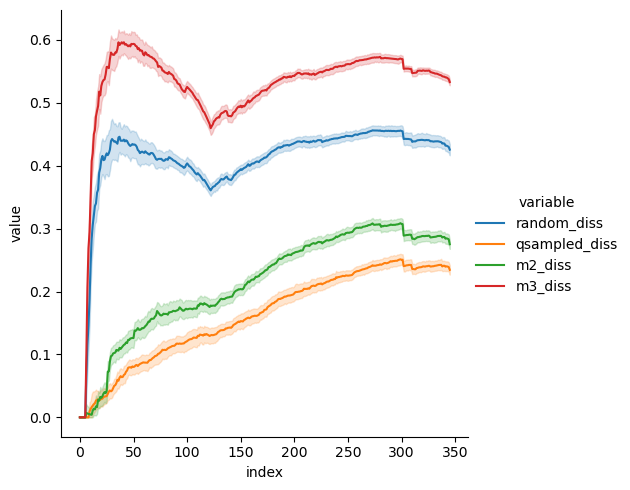

In [10]:
g = sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[
            ["random_diss", "qsampled_diss", "m2_diss", "m3_diss"]
        ].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

In [9]:
def _sns_plot_to_df(ax, line_idx=0):
    # get mean
    mean_p_df = pd.DataFrame(
        data={0: ax.lines[line_idx].get_xdata(), 1: ax.lines[line_idx].get_ydata()}
    )

    # get upper/lower conf. bounds
    p = ax.collections[line_idx].get_paths()
    p_df = pd.DataFrame(p[0].vertices).sort_values(by=[0, 1]).drop_duplicates()
    constant_bounds = p_df[~p_df[0].duplicated(keep=False)]
    p_df = pd.concat([p_df, constant_bounds]).sort_values(by=0)
    p_df["lim"] = [
        x
        for y in zip(np.tile("lower", len(mean_p_df)), np.tile("upper", len(mean_p_df)))
        for x in y
    ]

    # merge
    p_df_p = p_df.pivot(index=0, columns="lim").reset_index()
    p_df_p.columns = p_df_p.columns.to_flat_index()
    p_df_p = p_df_p.set_axis(["x", "ci_lower", "ci_upper"], axis="columns")
    df = pd.merge(p_df_p, mean_p_df, how="inner", left_on="x", right_on=0)

    df = df.rename(columns={1: "mean"}).drop(0, axis="columns")
    return df[["x", "mean", "ci_lower", "ci_upper"]]

<AxesSubplot:xlabel='x', ylabel='mean'>

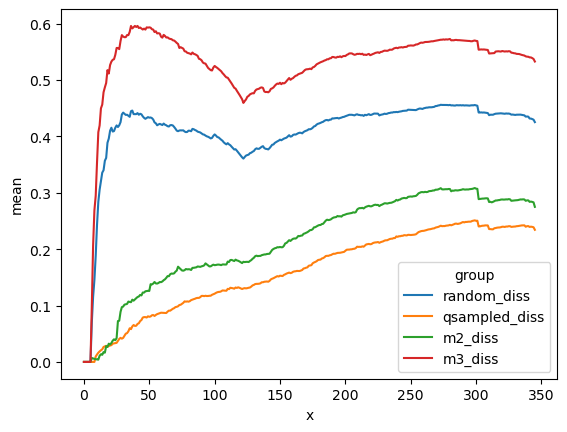

In [47]:
dpt = pd.concat(
    [
        _sns_plot_to_df(g.figure.gca(), i).assign(
            group=g.figure.gca().get_legend_handles_labels()[1][i]
        )
        for i in range(4)
    ]
)

sns.lineplot(data=dpt, x="x", y="mean", hue="group")

In [ ]:
dpt.to_csv("data/gibbons_global/global_disson_lin.csv", index=False)

## Log. diss.

In [10]:
mean_dfs_lg = [
    _compare_dissonance(
        samples,
        glbl["all"],
        glbl["pos"],
        order=entropy_order,
        diss_fcn=_diss_log,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

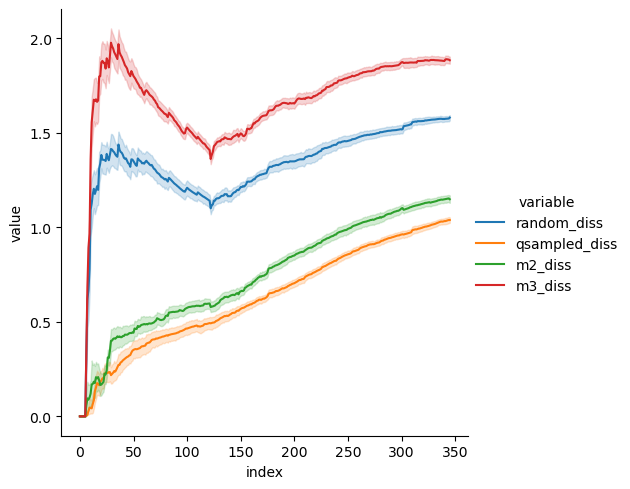

In [11]:
g_lg = sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs_lg)[
            ["random_diss", "qsampled_diss", "m2_diss", "m3_diss"]
        ].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

In [ ]:
print(
    tpl.get_tikz_code(
        g_lg.figure,
        standalone=False,
    )
)

<AxesSubplot:xlabel='x', ylabel='mean'>

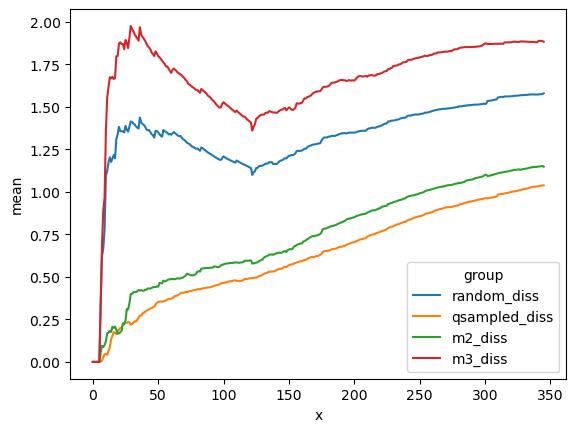

In [12]:
dpt = pd.concat(
    [
        _sns_plot_to_df(g_lg.figure.gca(), i).assign(
            group=g_lg.figure.gca().get_legend_handles_labels()[1][i]
        )
        for i in range(4)
    ]
)

sns.lineplot(data=dpt, x="x", y="mean", hue="group")

In [51]:
dpt.to_csv("data/gibbons_global/global_disson_log.csv", index=False)

In [14]:
dpt

,x,mean,ci_lower,ci_upper,group
0,0.0,0.000000,0.000000,0.000000,random_diss
1,1.0,0.000000,0.000000,0.000000,random_diss
2,2.0,0.000000,0.000000,0.000000,random_diss
3,3.0,0.000000,0.000000,0.000000,random_diss
4,4.0,0.000000,0.000000,0.000000,random_diss
...,...,...,...,...,...
341,341.0,1.888476,1.908714,1.867986,m3_diss
342,342.0,1.889260,1.907366,1.869749,m3_diss
343,343.0,1.888354,1.908415,1.867170,m3_diss
344,344.0,1.887356,1.866909,1.905104,m3_diss


In [15]:
dpt.query("ci_lower < mean & mean < ci_upper").to_csv(
    "data/gibbons_global/global_disson_log.csv", index=False
)

## Batch comparison

Repeat the comparison across multiple regenerations of qnets

In [4]:
def _get_mean_dfs(diss):
    df = pd.read_csv("data/gibbons_global/gibbons_global.csv")
    df_pos = pd.read_csv("data/gibbons_global/gibbons_global_pos.csv")
    df_neg = pd.read_csv("data/gibbons_global/gibbons_global_neg.csv")

    non_null_cols = (
        (df.isna().sum() < len(df))
        & (df_pos.isna().sum() < len(df_pos))
        & (df_neg.isna().sum() < len(df_neg))
    )

    glbl = _get_tnets(
        df,
        df_pos,
        df_neg,
    )

    samples = (
        df.loc[:, non_null_cols]
        .fillna(-9)
        .astype(int)
        .replace(-9, "")
        .to_numpy(dtype="<U21")
    )

    Ds = glbl["all"].predict_distributions(np.full_like(samples[0], fill_value=""))
    entrpy = list()
    for i in range(len(Ds)):
        entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
    entropy_order = pd.Series(entrpy).sort_values().index

    if diss == "log":
        mean_dfs = [
            _compare_dissonance(
                samples,
                glbl["all"],
                glbl["pos"],
                order=entropy_order,
                diss_fcn=_diss_log,
                plot=False,
            )
            for i in tqdm(range(20))
        ]

        pd.concat(mean_dfs).to_csv(
            "diss_log/mean_dfs_global_" + str(datetime.now()) + ".csv"
        )

    if diss == "linear":
        mean_dfs = [
            _compare_dissonance(
                samples,
                glbl["all"],
                glbl["pos"],
                order=entropy_order,
                diss_fcn=_diss_linear,
                plot=False,
            )
            for i in tqdm(range(20))
        ]

        pd.concat(mean_dfs).to_csv(
            "diss_linear/mean_dfs_global_" + str(datetime.now()) + ".csv"
        )

In [ ]:
[_get_mean_dfs("log") for i in tqdm(range(10))]

[_get_mean_dfs("linear") for i in tqdm(range(10))]

Now read/process/save log diss comparisons

In [23]:
diss_comp = pd.concat(
    [pd.read_csv(df) for df in glob.glob("diss_log/mean_dfs_global*.csv")]
)
diss_comp = diss_comp.rename(columns={diss_comp.columns[0]: "questions"})

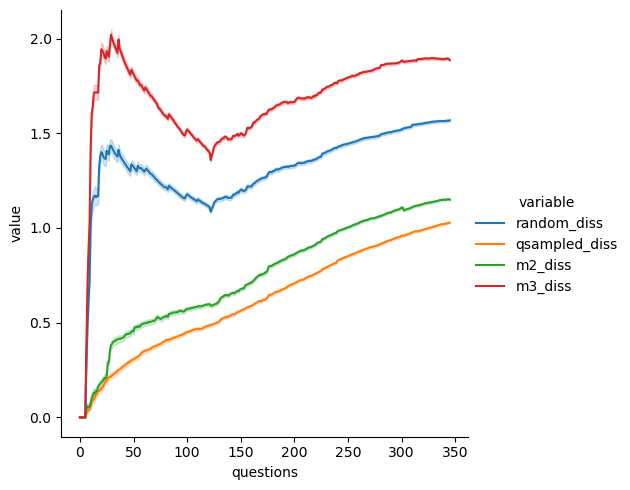

In [24]:
g_lg = sns.relplot(
    data=pd.melt(
        diss_comp[["questions", "random_diss", "qsampled_diss", "m2_diss", "m3_diss"]],
        id_vars="questions",
    ),
    x="questions",
    y="value",
    hue="variable",
    kind="line",
)

In [28]:
diss_comp_melt = pd.melt(
    diss_comp[["questions", "random_diss", "qsampled_diss", "m2_diss", "m3_diss"]],
    id_vars="questions",
)
diss_comp_melt

,questions,variable,value
0,0,random_diss,0.000000
1,1,random_diss,0.000000
2,2,random_diss,0.000000
3,3,random_diss,0.000000
4,4,random_diss,0.000000
...,...,...,...
276795,341,m3_diss,1.914402
276796,342,m3_diss,1.915032
276797,343,m3_diss,1.914435
276798,344,m3_diss,1.913342


In [32]:
conf = 0.95

diss_comp_ci_var = diss_comp_melt.groupby(
    ["questions", "variable"], as_index=False
).agg(
    mean=pd.NamedAgg(column="value", aggfunc="mean"),
    var=pd.NamedAgg(column="value", aggfunc="var"),
    ci=pd.NamedAgg(
        column="value",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

diss_comp_ci_var

,questions,variable,mean,var,ci
0,0,m2_diss,0.000000,0.000000,"(0.0, 0.0)"
1,0,m3_diss,0.000000,0.000000,"(0.0, 0.0)"
2,0,qsampled_diss,0.000000,0.000000,"(0.0, 0.0)"
3,0,random_diss,0.000000,0.000000,"(0.0, 0.0)"
4,1,m2_diss,0.000000,0.000000,"(0.0, 0.0)"
...,...,...,...,...,...
1379,344,random_diss,1.566195,0.002902,"(1.5586827522277833, 1.5737066933035986)"
1380,345,m2_diss,1.149536,0.001571,"(1.1440089329842429, 1.1550633684208809)"
1381,345,m3_diss,1.887070,0.002592,"(1.8799715224256015, 1.8941686364192412)"
1382,345,qsampled_diss,1.028118,0.001392,"(1.0229152679102593, 1.0333203509839308)"


In [36]:
diss_comp_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(
    "data/dissonance_comparison/global/diss_comp_global_log_ci_var.csv", index=False
)

Do the same for linear

,questions,variable,mean,var,ci
0,0,m2_diss,0.000000,0.000000,"(0.0, 0.0)"
1,0,m3_diss,0.000000,0.000000,"(0.0, 0.0)"
2,0,qsampled_diss,0.000000,0.000000,"(0.0, 0.0)"
3,0,random_diss,0.000000,0.000000,"(0.0, 0.0)"
4,1,m2_diss,0.000000,0.000000,"(0.0, 0.0)"
...,...,...,...,...,...
1379,344,random_diss,0.427699,0.000391,"(0.42494039945317763, 0.4304574865740258)"
1380,345,m2_diss,0.281152,0.000249,"(0.27895024852316264, 0.2833532649903878)"
1381,345,m3_diss,0.530099,0.000232,"(0.52797555147476, 0.5322224611349998)"
1382,345,qsampled_diss,0.235653,0.000271,"(0.2333572627316346, 0.23794931830529764)"


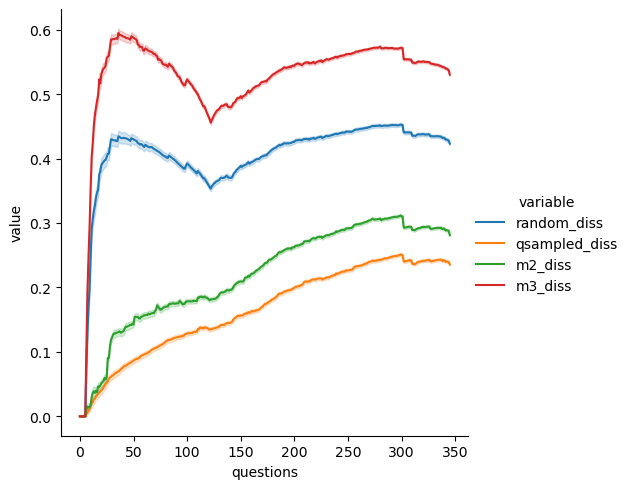

In [37]:
diss_comp = pd.concat(
    [pd.read_csv(df) for df in glob.glob("diss_linear/mean_dfs_global*.csv")]
)
diss_comp = diss_comp.rename(columns={diss_comp.columns[0]: "questions"})

g = sns.relplot(
    data=pd.melt(
        diss_comp[["questions", "random_diss", "qsampled_diss", "m2_diss", "m3_diss"]],
        id_vars="questions",
    ),
    x="questions",
    y="value",
    hue="variable",
    kind="line",
)

diss_comp_melt = pd.melt(
    diss_comp[["questions", "random_diss", "qsampled_diss", "m2_diss", "m3_diss"]],
    id_vars="questions",
)
diss_comp_melt


diss_comp_ci_var = diss_comp_melt.groupby(
    ["questions", "variable"], as_index=False
).agg(
    mean=pd.NamedAgg(column="value", aggfunc="mean"),
    var=pd.NamedAgg(column="value", aggfunc="var"),
    ci=pd.NamedAgg(
        column="value",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

diss_comp_ci_var

In [38]:
diss_comp_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(
    "data/dissonance_comparison/global/diss_comp_global_linear_ci_var.csv", index=False
)